### Pedro Saturio Toledano Montes

<div style="text-align: center; color: cian; font-size: 30pt; font-weight: bold;">
Predicción de la inserción laboral de estudiantes (MLFlow)
</div>


## Introducción

Este proyecto busca predecir la empleabilidad de estudiantes en función de su rendimiento académico, experiencia y habilidades, utilizando modelos de machine learning. Para ello, se entrenarán y compararán varios modelos de clasificación, registrando sus ejecuciones con MLFlow.

Uno de los modelos utilizará autologging, mientras que el otro se registrará manualmente, permitiendo un mayor control sobre las métricas y parámetros. A través de experimentación y ajuste de hiperparámetros, se buscará optimizar el rendimiento y seleccionar el modelo más efectivo.

## Inicializamos el entorno

In [76]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import cross_validate
from sklearn.metrics import roc_auc_score, f1_score, accuracy_score
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import mlflow

In [77]:
df = pd.read_csv('/Users/pedrotoledano/Desktop/MIOTI/MLOps/Challenges/Challenge_1/placementdata.csv')
df.head()

,StudentID,CGPA,Internships,Projects,Workshops/Certifications,AptitudeTestScore,SoftSkillsRating,ExtracurricularActivities,PlacementTraining,SSC_Marks,HSC_Marks,PlacementStatus
0,1,7.5,1,1,1,65,4.4,No,No,61,79,NotPlaced
1,2,8.9,0,3,2,90,4.0,Yes,Yes,78,82,Placed
2,3,7.3,1,2,2,82,4.8,Yes,No,79,80,NotPlaced
3,4,7.5,1,1,2,85,4.4,Yes,Yes,81,80,Placed
4,5,8.3,1,2,2,86,4.5,Yes,Yes,74,88,Placed


Este conjunto de datos contiene información sobre el rendimiento académico, la formación y el estado laboral de los estudiantes.

- **CGPA:** Promedio general de calificaciones obtenido por el estudiante.

- **Internships:** Número de prácticas que ha realizado un estudiante.

- **Projects:** Número de proyectos en los que ha trabajado el estudiante.

- **Workshops/Certifications:** Cursos y certificaciones que los estudiantes realizan online para mejorar sus habilidades.

- **AptitudeTestScore:** Puntaje en pruebas de aptitud, utilizadas en procesos de reclutamiento para evaluar el razonamiento cuantitativo y lógico del estudiante.

- **SoftSkillRating:** Calificación de habilidades blandas, donde la comunicación juega un papel clave en la empleabilidad y en diversos aspectos de la vida.

- **ExtraCurricularActivities:** Actividades extracurriculares.

- **PlacementTraining:** Programas de formación ofrecido por las universidades para preparar a los estudiantes para el proceso de búsqueda de empleo.

- **SSC_Marks:** Calificaciones obtenidas en la educación secundaria.

- **HCS_Marks:** Calificaciones obtenidas en bachillerato.

- **PlacementStatus:** Columna objetivo del conjunto de datos, con dos categorías: "Placed" (colocado en un empleo) y "Not Placed" (no colocado).

In [78]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
StudentID,10000.0,5000.50000,2886.895680,1.0,2500.75,5000.5,7500.25,10000.0
CGPA,10000.0,7.69801,0.640131,6.5,7.40,7.7,8.20,9.1
Internships,10000.0,1.04920,0.665901,0.0,1.00,1.0,1.00,2.0
Projects,10000.0,2.02660,0.867968,0.0,1.00,2.0,3.00,3.0
Workshops/Certifications,10000.0,1.01320,0.904272,0.0,0.00,1.0,2.00,3.0
AptitudeTestScore,10000.0,79.44990,8.159997,60.0,73.00,80.0,87.00,90.0
SoftSkillsRating,10000.0,4.32396,0.411622,3.0,4.00,4.4,4.70,4.8
SSC_Marks,10000.0,69.15940,10.430459,55.0,59.00,70.0,78.00,90.0
HSC_Marks,10000.0,74.50150,8.919527,57.0,67.00,73.0,83.00,88.0


In [79]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   StudentID                  10000 non-null  int64  
 1   CGPA                       10000 non-null  float64
 2   Internships                10000 non-null  int64  
 3   Projects                   10000 non-null  int64  
 4   Workshops/Certifications   10000 non-null  int64  
 5   AptitudeTestScore          10000 non-null  int64  
 6   SoftSkillsRating           10000 non-null  float64
 7   ExtracurricularActivities  10000 non-null  object 
 8   PlacementTraining          10000 non-null  object 
 9   SSC_Marks                  10000 non-null  int64  
 10  HSC_Marks                  10000 non-null  int64  
 11  PlacementStatus            10000 non-null  object 
dtypes: float64(2), int64(7), object(3)
memory usage: 937.6+ KB


## Inicializamos MLFlow

In [80]:
from mlflow import MlflowClient
from pprint import pprint

In [81]:
client = MlflowClient(tracking_uri="http://127.0.0.1:8080")

In [82]:
# Provide an Experiment description that will appear in the UI
experiment_description = (
    "Este es el proyecto de predicción de empleabilidad estudiantil. "
    "Este experimento entrena modelos para clasificar el estado de inserción laboral de los estudiantes."
)

# Provide searchable tags that define characteristics of the Runs that
# will be in this Experiment
experiment_tags = {
    "project_name": "prediccion-empleabilidad",
    "store_dept": "produce",
    "team": "stores-ml",
    "project_quarter": "Q3-2023",
    "mlflow.note.content": experiment_description,
}

# Comentamos porque ya lo tenemos creado

#Create the Experiment, providing a unique name
#produce_empleabilidad_experiment = client.create_experiment(
#    name="Modelo_empleabilidad", tags=experiment_tags)

In [83]:
# Sets the current active experiment to the "Modelo_empleabilidad" experiment and
# returns the Experiment metadata
apple_experiment = mlflow.set_experiment("Modelo_empleabilidad")

# Define a run name for this iteration of training.
# If this is not set, a unique name will be auto-generated for your run.
run_name = "empleabilidad_rf_test"

# Define an artifact path that the model will be saved to.
artifact_path = "rf_empleabilidad"

In [84]:
# Use search_experiments() to search on the project_name tag key

empleabilidad_experiment = client.search_experiments(
    filter_string="tags.`project_name` = 'prediccion-empleabilidad'"
)

print(vars(empleabilidad_experiment[0]))

{'_experiment_id': '480937964823011105', '_name': 'Modelo_empleabilidad', '_artifact_location': 'mlflow-artifacts:/480937964823011105', '_lifecycle_stage': 'active', '_tags': {'project_name': 'prediccion-empleabilidad', 'project_quarter': 'Q3-2023', 'mlflow.note.content': 'Este es el proyecto de predicción de empleabilidad estudiantil. Este experimento entrena modelos para clasificar el estado de inserción laboral de los estudiantes.', 'store_dept': 'produce', 'team': 'stores-ml'}, '_creation_time': 1743156588516, '_last_update_time': 1743156588516}


## Preprocesamiento y análisis de los datos

In [85]:
df.tail()

,StudentID,CGPA,Internships,Projects,Workshops/Certifications,AptitudeTestScore,SoftSkillsRating,ExtracurricularActivities,PlacementTraining,SSC_Marks,HSC_Marks,PlacementStatus
9995,9996,7.5,1,1,2,72,3.9,Yes,No,85,66,NotPlaced
9996,9997,7.4,0,1,0,90,4.8,No,No,84,67,Placed
9997,9998,8.4,1,3,0,70,4.8,Yes,Yes,79,81,Placed
9998,9999,8.9,0,3,2,87,4.8,Yes,Yes,71,85,Placed
9999,10000,8.4,0,1,1,66,3.8,No,No,62,66,NotPlaced


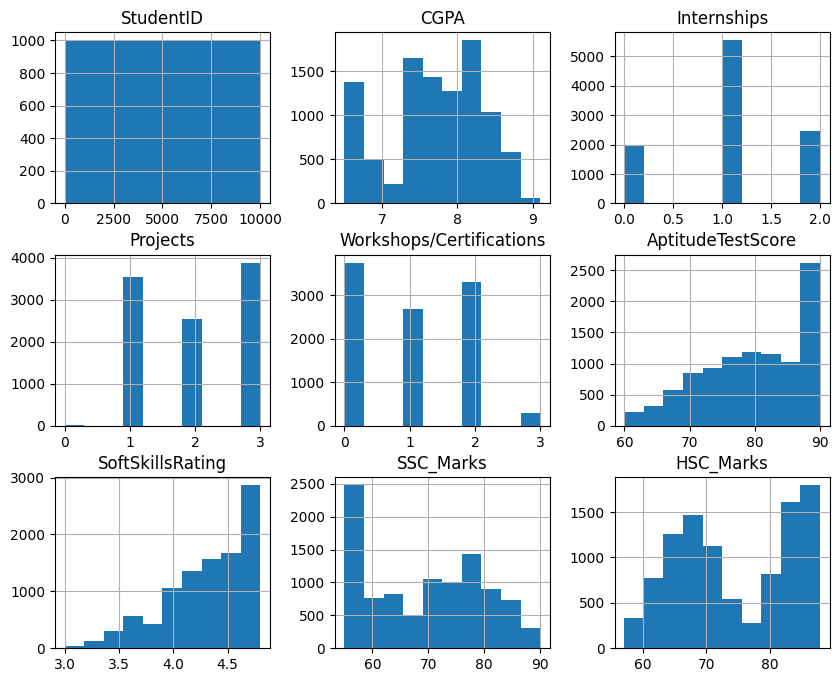

In [86]:
df.hist(figsize=(10, 8));

- CGPA sigue una distribución normal o casi normal, lo cual es esperado debido al teorema del límite central, ya que es una métrica agregada del desempeño académico de los estudiantes.

- AptitudeTestScore y SoftSkillsRating muestran asimetría a la izquierda, indicando que la mayoría de los estudiantes obtuvo puntuaciones medias o altas, con pocos valores bajos.

- SSC_Marks presenta asimetría a la derecha, lo que sugiere que la mayoría de los estudiantes en la etapa de la ESO obtuvo calificaciones bajas.

- En la variable HSC_Marks, se observa una distribución bimodal, con dos picos: uno alrededor de una media de 70 y otro asociado a aquellos estudiantes que, al final del ciclo, se juegan la nota para ingresar a la universidad, lo que eleva la media a 95/100.

In [87]:
# Mapeamos las variables para convertirlas a formato numérico

df['ExtracurricularActivities'] = df['ExtracurricularActivities'].map({'Yes': 1, 'No':0})
df['PlacementTraining'] = df['PlacementTraining'].map({'Yes': 1, 'No':0})
df['PlacementStatus'] = df['PlacementStatus'].map({'Placed': 1, 'NotPlaced':0})


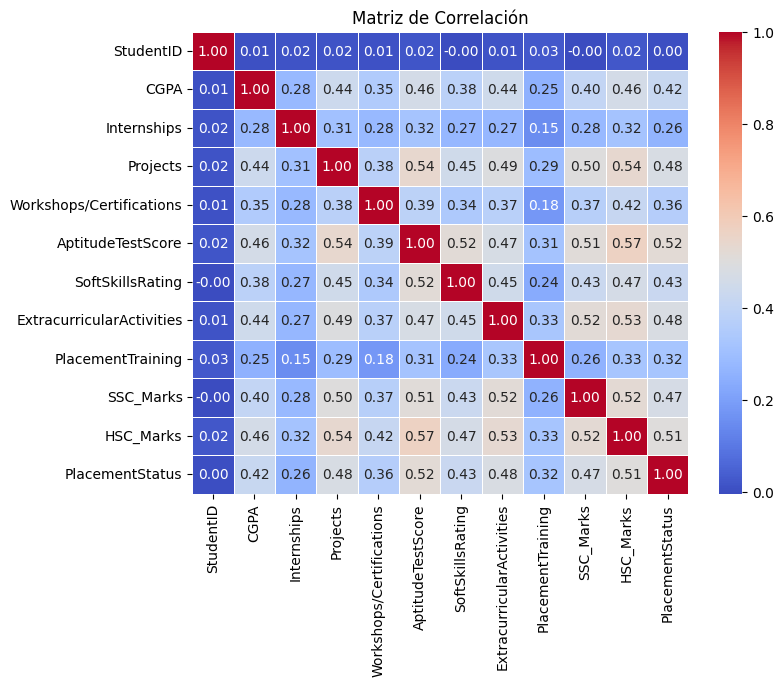

In [88]:
corr_matrix = df.corr()

# Graficar matriz de correlación
plt.figure(figsize=(8, 6))  # Ajustar tamaño
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Matriz de Correlación")
plt.show()

In [89]:
df.isna().sum()

StudentID                    0
CGPA                         0
Internships                  0
Projects                     0
Workshops/Certifications     0
AptitudeTestScore            0
SoftSkillsRating             0
ExtracurricularActivities    0
PlacementTraining            0
SSC_Marks                    0
HSC_Marks                    0
PlacementStatus              0
dtype: int64

No tenemos ningún nulo en nuestro dataset

## Ajustamos los datos para los modelos

In [90]:
X = df[['CGPA','Internships','Projects', 'Workshops/Certifications', 'AptitudeTestScore', 'SoftSkillsRating', 'ExtracurricularActivities', 'PlacementTraining', 'SSC_Marks', 'HSC_Marks']]
y = df['PlacementStatus']

In [91]:
X.shape

(10000, 10)

In [92]:
y.shape

(10000,)

Dividimos el dataset entre train y test

In [93]:
X_train,X_test,y_train,y_test=train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [94]:
X_train.shape, y_train.shape

((8000, 10), (8000,))

In [95]:
X_test.shape, y_test.shape

((2000, 10), (2000,))

In [96]:
# Normalizamos los datos ya que están en distintas escalas

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [98]:
np.set_printoptions(threshold=np.inf)

X_train

array([[-1.56088920e+00, -7.80111366e-02, -1.18451217e+00,
        -1.11442445e+00, -5.39061411e-01, -1.52376411e+00,
        -1.18484014e+00, -1.65954996e+00, -1.07493173e+00,
        -9.50077264e-01],
       [ 1.09547804e+00, -7.80111366e-02,  1.12532265e+00,
        -1.11442445e+00,  1.29849133e+00,  6.67257315e-01,
         8.43995715e-01,  6.02573003e-01,  8.46927190e-01,
         1.40385346e+00],
       [-1.09211851e+00, -7.80111366e-02, -2.95947585e-02,
        -1.11442445e+00, -1.27408251e+00,  9.10704140e-01,
        -1.18484014e+00,  6.02573003e-01, -1.17102467e+00,
        -1.06216920e+00],
       [-1.71714610e+00, -7.80111366e-02, -2.95947585e-02,
        -1.11442445e+00,  1.05348430e+00, -7.93423632e-01,
        -1.18484014e+00, -1.65954996e+00,  8.46927190e-01,
        -8.37985325e-01],
       [-1.56088920e+00, -7.80111366e-02, -1.18451217e+00,
        -1.11442445e+00, -6.61564927e-01, -2.01065775e+00,
        -1.18484014e+00, -1.65954996e+00, -4.02281106e-01,
        -1.

## Modelo 1 - DecisionTreeClassifier - Logging Manual

In [71]:
from sklearn.tree import DecisionTreeClassifier
import mlflow

params = {
    "max_depth": 4,
    "min_samples_split": 2,
    "min_samples_leaf": 1,
    "criterion": "gini",  # O "entropy" si prefieres
    "random_state": 42,
}


tree = DecisionTreeClassifier(**params)
tree.fit(X_train, y_train)
y_pred = tree.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

metrics = {"accuracy": accuracy, "precision": precision, "recall": recall, "f1": f1}

print(accuracy)
# Configura la URI de seguimiento
mlflow.set_tracking_uri('http://127.0.0.1:8080')

# Establece el experimento utilizando su ID
#experiment_id = "480937964823011105"
mlflow.set_experiment('Modelo_empleabilidad')

# Initiate the MLflow run context
with mlflow.start_run(run_name='DecissionTreeClassfier') as run:
    # Log the parameters used for the model fit
    mlflow.log_params(params)

    # Log the error metrics that were calculated during validation
    mlflow.log_metrics(metrics)

    # Log an instance of the trained model for later use
    mlflow.sklearn.log_model(
        sk_model=tree, input_example=X_test, artifact_path=artifact_path
    )


2025/03/30 21:09:23 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'ca598bc7d1ec4047944c7b1b13bd1937', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow
2025/03/30 21:09:23 WARNING mlflow.sklearn: Failed to log training dataset information to MLflow Tracking. Reason: 'Series' object has no attribute 'flatten'


🏃 View run carefree-cat-797 at: http://127.0.0.1:8080/#/experiments/480937964823011105/runs/ca598bc7d1ec4047944c7b1b13bd1937
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/480937964823011105
0.7875
🏃 View run DecissionTreeClassfier at: http://127.0.0.1:8080/#/experiments/480937964823011105/runs/49fb7669ff5b43cba0f193bfa3fcde9c
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/480937964823011105


# Modelo 2 - RandomForestClassifier - Logging Manual

In [72]:
from sklearn.ensemble import RandomForestClassifier

params = {
    "n_estimators": 5,              # Número de árboles en el bosque
    "criterion": "entropy",            # Criterio de división ('gini' o 'entropy')
    "max_depth": None,                 # Profundidad máxima de los árboles (None es ilimitado)
    "min_samples_split": 2,            # Mínimo de muestras necesarias para dividir un nodo
    "min_samples_leaf": 1,             # Mínimo de muestras en una hoja
    "bootstrap": True,                 # Usar muestras con reemplazo
    "oob_score": False,                # Calcular el puntaje OOB
    "random_state": 42, 
}

tree = RandomForestClassifier() 
tree.fit(X_train, y_train)
y_pred = tree.predict(X_test) # *****

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(accuracy)
metrics = {"accuracy": accuracy, "precision": precision, "recall": recall, "f1": f1}

# Configura la URI de seguimiento
mlflow.set_tracking_uri('http://127.0.0.1:8080')

# Establece el experimento utilizando su ID
#experiment_id = "480937964823011105"
mlflow.set_experiment('Modelo_empleabilidad')

# Initiate the MLflow run context
with mlflow.start_run(run_name='RandomForestClassfier') as run:
    # Log the parameters used for the model fit
    mlflow.log_params(params)

    # Log the error metrics that were calculated during validation
    mlflow.log_metrics(metrics)

    # Log an instance of the trained model for later use
    mlflow.sklearn.log_model(
        sk_model=tree, input_example=X_test, artifact_path=artifact_path
    )



2025/03/30 21:09:26 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '816a132fcdc641eca13b99810d8ced39', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow
2025/03/30 21:09:26 WARNING mlflow.sklearn: Failed to log training dataset information to MLflow Tracking. Reason: 'Series' object has no attribute 'flatten'


🏃 View run thundering-elk-285 at: http://127.0.0.1:8080/#/experiments/480937964823011105/runs/816a132fcdc641eca13b99810d8ced39
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/480937964823011105
0.7895
🏃 View run RandomForestClassfier at: http://127.0.0.1:8080/#/experiments/480937964823011105/runs/e6983fb53f1c4a21912f86192e755bdc
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/480937964823011105


## Modelo 3 - KNN - Autologging

In [75]:
from sklearn.neighbors import KNeighborsClassifier

params = {
    "n_neighbors": 9,         # Número de vecinos
    "weights": "uniform",    # Pesos ('uniform' o 'distance')
    "algorithm": "auto",     # Algoritmo usado para encontrar los vecinos
    "p": 2                    # Distancia (p=2 es distancia euclidiana)
}

knn = KNeighborsClassifier(**params)
knn.fit(X_train, y_train)

y_pred = knn.predict(X_test) 

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(accuracy)

# Configurar la URI de seguimiento de MLflow
mlflow.set_tracking_uri('http://127.0.0.1:8080')
mlflow.set_experiment('Modelo_empleabilidad')
mlflow.autolog()


2025/03/30 21:10:00 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '13f90eb8ba4d4ee4a9592b88e62ce4cb', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current sklearn workflow
2025/03/30 21:10:00 WARNING mlflow.sklearn: Failed to log training dataset information to MLflow Tracking. Reason: 'Series' object has no attribute 'flatten'
2025/03/30 21:10:02 INFO mlflow.tracking.fluent: Autologging successfully enabled for sklearn.
2025/03/30 21:10:02 WARNING mlflow.utils.autologging_utils: MLflow xgboost autologging is known to be compatible with 1.4.2 <= xgboost <= 2.1.4, but the installed version is 3.0.0. If you encounter errors during autologging, try upgrading / downgrading xgboost to a compatible version, or try upgrading MLflow.
2025/03/30 21:10:02 INFO mlflow.tracking.fluent: Autologging successfully enabled for xgboost.


🏃 View run smiling-grub-109 at: http://127.0.0.1:8080/#/experiments/480937964823011105/runs/13f90eb8ba4d4ee4a9592b88e62ce4cb
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/480937964823011105
0.7905


## Modelo 4 - XGBoostClassifier - Logging Manual

In [74]:
import xgboost as xgb

params = {
    "objective": "binary:logistic",  # Tipo de problema: clasificación binaria
    "learning_rate": 0.01,           # Tasa de aprendizaje
    "max_depth": 6,                 # Profundidad máxima de los árboles
    "n_estimators": 100,            # Número de árboles (estimadores)
    "colsample_bytree": 0.9,        # Proporción de características por árbol
    "random_state": 42   
}

xgb_model = xgb.XGBClassifier(**params)
xgb_model.fit(X_train, y_train)

y_pred = xgb_model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(accuracy)

# Configura la URI de seguimiento
mlflow.set_tracking_uri('http://127.0.0.1:8080')

# Establece el experimento utilizando su ID
#experiment_id = "480937964823011105"
mlflow.set_experiment('Modelo_empleabilidad')
mlflow.autolog()


2025/03/30 21:09:38 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '6bcbc34402f54174a76b1e10013f6ba6', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current xgboost workflow
2025/03/30 21:09:38 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "/opt/anaconda3/envs/MLOps/lib/python3.13/site-packages/xgboost/sklearn.py:1028: UserWarning: [21:09:38] WARNING: /Users/runner/work/xgboost/xgboost/src/c_api/c_api.cc:1427: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats."
2025/03/30 21:09:39 INFO mlflow.tracking.fluent: Autologging successfully enabled for sklearn.
2025/03/30 21:09:39 WARNING mlflow.utils.autologging_utils: MLflow xgboost autologging is known to be compatible with 1.4.2 <= xgboost <= 2.1.4, but the installed version is 3.0.0. If you encounter errors during autologging, try upgrad

🏃 View run rumbling-foal-106 at: http://127.0.0.1:8080/#/experiments/480937964823011105/runs/6bcbc34402f54174a76b1e10013f6ba6
🧪 View experiment at: http://127.0.0.1:8080/#/experiments/480937964823011105
0.804


#### A continuación, analizaremos los resultados con MLFlow para decantarnos por el mejor modelo.

## Conclusión

Tras realizar varias ejecuciones y comparar los resultados de los distintos modelos, seleccionamos el modelo de XGBoost como el más eficiente. La ejecución identificada como (ad9352a3518f4b8e9c3b88308122abef), con un accuracy de 0.804, demostró ser la que ofreció el mejor rendimiento en términos de precisión.